Neural Network based Strategy



## In this project has following topics:

- Feature Engineering
- Neural Network Creation
- Strategy Backtesting



## Part 1 - Training a neural network

In [148]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Apply the default seaborn theme, scaling, and color palette
sns.set()
# One can use different colour palettes
# palettes = ["deep", "muted", "pastel", "bright", "dark", "colorblind"]
# sns.set(palette="deep")

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

In [149]:
import yfinance as yf
ticker = 'KAJARIACER.NS'
df = yf.download(ticker, period='2y',auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [150]:
# Copying the original dataframe. Will work on the new dataframe.
data = df.copy()
# Checking the shape
print('Number of observations:', data.shape[0])
print('Number of variables:', data.shape[1])

Number of observations: 493
Number of variables: 5


In [151]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,KAJARIACER.NS,KAJARIACER.NS,KAJARIACER.NS,KAJARIACER.NS,KAJARIACER.NS
Date,,,,,
2023-07-31,1415.737061,1418.100586,1381.663279,1393.431496,184594
2023-08-01,1417.263428,1427.948397,1408.498755,1423.024437,594258
2023-08-02,1406.381470,1425.978855,1391.018738,1418.100519,260571
2023-08-03,1407.464844,1420.070231,1398.503260,1408.843577,206367
2023-08-04,1426.077393,1429.918106,1408.498878,1414.850739,406569


### Feature Engineering

In [152]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

In [153]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'co']

In addition, We'll use popular technical indicators to build features. They are as follows:

- [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands)
- [Moving Average Convergence/Divergence (MACD)](https://en.wikipedia.org/wiki/MACD)
- [Parabolic Stop And Reverse (SAR)](https://en.wikipedia.org/wiki/Parabolic_SAR)


The discussion about what these technical indicators and how they are built, is out of scope of this session. We'll use `TA-LIB` library to build these indicators.

In [154]:
print(type(data['Close']))
print(data['Close'].shape)


<class 'pandas.core.frame.DataFrame'>
(493, 1)


In [155]:
# Use the following command on the terminal window on Anaconda to install ta-lib if it is not installed
# conda install -c conda-forge ta-lib
import talib as ta

In [156]:
close = data['Close'].iloc[:, 0]  # Convert to Series
high = data['High'].iloc[:, 0]
low = data['Low'].iloc[:, 0]

data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(close)
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(close)
data['sar'] = ta.SAR(high, low)

features_list += ['upper_band', 'middle_band', 'lower_band', 'macd', 'sar']


ML algorithms don't work with `NaN` values. However, while creating the above features, we would have many `NaN` values we need to drop from our dataset.

In [157]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'co',
 'upper_band',
 'middle_band',
 'lower_band',
 'macd',
 'sar']

In [158]:
data[features_list].head()

Price,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,co,upper_band,middle_band,lower_band,macd,sar
Ticker,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2023-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.305565,NaN,NaN,NaN,NaN,NaN
2023-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.761009,NaN,NaN,NaN,NaN,1381.663279
2023-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.719049,NaN,NaN,NaN,NaN,1382.588981
2023-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005830,NaN,NaN,-1.378733,NaN,NaN,NaN,NaN,1383.496170
2023-08-04,8.040069,NaN,NaN,NaN,NaN,NaN,NaN,0.006316,NaN,NaN,11.226654,1428.967352,1414.584839,1400.202326,NaN,1384.385214


There are null values in many columns. Let's drop them.

In [159]:
data.dropna(inplace=True)

In [160]:
data[features_list].head()

Price,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,co,upper_band,middle_band,lower_band,macd,sar
Ticker,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2023-09-15,18.776543,44.017515,40.990931,1394.532605,1407.778695,1418.604340,1422.263525,-0.026865,-0.061168,-0.082695,-44.406681,1391.357299,1357.768799,1324.180298,-18.600818,1429.716355
2023-09-18,17.856578,41.360470,40.565154,1387.338721,1402.562598,1413.700085,1419.994570,0.003769,-0.020931,-0.059732,35.229252,1388.764277,1356.821460,1324.878643,-18.772731,1416.238176
2023-09-20,17.891122,35.070213,42.507288,1376.641650,1397.816406,1407.808948,1416.512651,-0.009127,-0.017414,-0.070889,-18.009377,1386.191283,1354.186670,1322.182057,-20.322991,1404.377380
2023-09-21,18.089373,25.781084,44.864297,1365.253796,1392.316797,1401.869751,1413.033647,0.008996,-0.017870,-0.052173,-12.384578,1380.763161,1348.403906,1316.044652,-22.293929,1393.939879
2023-09-22,20.177994,24.435102,45.821447,1356.101074,1383.640389,1395.950867,1407.370864,-0.037652,-0.033884,-0.058583,-18.108033,1375.647665,1339.552173,1303.456680,-25.028565,1384.754878


We use only technical indicators and quantitative features for this exercise. Below we define feature matrix `X`, create the target variable and assign it to the target vector `y`.

In [161]:
import numpy as np

In [162]:
X = data[features_list]
data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
y = data['target']

We will use `train_test_split()` function from the `sklearn.model_selection` package to split our dataset. We will use 20% of our dataset as a test dataset.

In [163]:
from sklearn.model_selection import train_test_split

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [165]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((368, 16), (92, 16), (368,), (92,))

Before we can train our neural network, we need to make sure that our data is scaled, that is, it ranges between 0 and 1. We will use `StandardScaler` from the `sklearn.preprocessing` package. We need to train the scaler object on training data only and then apply on training and testing set both.

In [166]:
from sklearn.preprocessing import StandardScaler

In [167]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [168]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#sns.pairplot(X_train_scaled_df[features_list]);

In [169]:
X_train_scaled_df.describe().round(2)

Price,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,co,upper_band,middle_band,lower_band,macd,sar
Ticker,,,,,,,,,,,,,,,,
count,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00,368.00
mean,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.42,-1.55,-1.91,-2.77,-2.88,-2.97,-2.99,-3.21,-2.73,-2.44,-2.88,-2.70,-2.69,-2.64,-2.03,-2.80
25%,-0.78,-0.77,-0.72,-0.46,-0.49,-0.49,-0.52,-0.64,-0.65,-0.69,-0.63,-0.42,-0.45,-0.51,-0.74,-0.59
50%,-0.18,-0.17,-0.06,0.01,0.00,0.02,0.07,-0.05,-0.12,-0.13,-0.08,0.02,0.06,0.13,-0.14,0.04
75%,0.55,0.59,0.54,0.75,0.74,0.72,0.72,0.51,0.64,0.65,0.56,0.68,0.74,0.76,0.75,0.75
max,4.49,3.52,3.50,1.67,1.63,1.56,1.51,3.34,3.17,3.27,4.12,1.76,1.77,1.82,2.87,2.03


We have everything ready now. Now is the time to create our first neural network. We'll use the `MLPClassifier` from the `sklearn.neural_network` package. Here, MLP stands for Multi Layer Perceptron. A simple neural network is shown below:

![Neural Network](https://www.learnopencv.com/wp-content/uploads/2017/10/mlp-diagram-600x400.jpg)

We can see that a neural network consists of

- Input layer,
- Hidden layer, and 
- Output layer

Hence, we need to define these layers for the model. In our case, the feature matrix `X` becomes input to the input layer. Then we have hidden layer/s and finally the output layer. In the above diagram, we have only one hidden layer.

    Note: In `sklearn` library, we need not specify the size of the input and output layer. It will be fixed by the library itself when we train it. Hence, we are only to define hidden layer sizes.

Below we define the model:

In [170]:
from sklearn.neural_network import MLPClassifier

In [171]:
# Define model
# model = MLPClassifier(hidden_layer_sizes=(5), verbose=True, random_state=10)
model = MLPClassifier(hidden_layer_sizes=(5), max_iter=300, activation = 'tanh', solver='adam', random_state=1, shuffle=False)

# Train model
model.fit(X_train_scaled, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=5, max_iter=300,
              random_state=1, shuffle=False)

we have successfully trained our first neural network. Now let's check its properties

In [172]:
# Check number of layers in the model
model.n_layers_

3

In [173]:
model.get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 5,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': False,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [174]:
# Check weights
print('Weights between input layer and the hidden layer:')
print(model.coefs_[0])
print('Biases between input layer and the hidden layer:')
print(model.intercepts_[0])

Weights between input layer and the hidden layer:
[[ 0.10321599 -0.06732241 -0.3294174   0.01359576 -0.21105317]
 [-0.22285432 -0.61175315  0.12923874  0.13348285  0.2361676 ]
 [ 0.16009138 -0.08934079 -0.049923    0.63269973 -0.32421577]
 [ 0.18870073 -0.10694426  0.04831083 -0.34731147 -0.26047961]
 [ 0.35008018  0.46310575 -0.19143526  0.24644584  0.48081229]
 [ 0.45292023 -0.48168916 -0.4856696  -0.3329961   0.48783774]
 [-0.37167134 -0.16118761  0.51091655  0.07928679  0.30788046]
 [-0.08462586 -0.11806265  0.53214983 -0.7559892   0.2687876 ]
 [ 0.55943974 -0.12062347 -0.05462065  0.05436446 -0.52498723]
 [-0.09621781  0.20803147 -0.34779196 -0.47283995 -0.49378207]
 [-0.23197768 -0.22485812 -0.0136162  -0.05375568  0.24712805]
 [-0.43311688 -0.03070995 -0.31112065  0.16992186  0.29296658]
 [-0.42783222 -0.13228977  0.18434911 -0.08778391 -0.42835542]
 [-0.00960958  0.20371113 -0.0592432   0.40771105  0.11578319]
 [ 0.37454754 -0.37272839 -0.21404126  0.42091225 -0.28354931]
 [-0.

In [175]:
print('Weights between hidden layer and the output layer:')
print(model.coefs_[1])
print('Biases between hidden layer and the output layer:')
print(model.intercepts_[1])

Weights between hidden layer and the output layer:
[[ 0.61032882]
 [-0.39288887]
 [ 0.76859779]
 [ 0.61516842]
 [ 0.20427518]]
Biases between hidden layer and the output layer:
[-0.56835375]


In [176]:
# Check model accuracy on training data
print('Model accuracy on training data:', model.score(X_train_scaled, y_train))

Model accuracy on training data: 0.5978260869565217


In [177]:
# Check model accuracy on testing data
print('Model accuracy on testing data:', model.score(X_test_scaled, y_test))

Model accuracy on testing data: 0.5652173913043478


In [178]:
# Predict data
y_pred = model.predict(X_test_scaled)

In [179]:
y_pred

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
        1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1])

As training and testing accuracy are very similar, we can consider that model might not have overfitted, and it may generalize well. However, it is difficult to claim until we evaluate the model properly.

Also, the model that we have created is a very simple one; we have used most of the default parameters for building the model. And they might not be the best one. 

In [180]:
# Calculate Precision and Recall
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.568177613320999
Recall: 0.5652173913043478


## Part 2 - Backtesting our predictions

So far we've covered
* Read Data
* Create Features
* Scale data
* Use already trained model to make predictions
* Trade on those prediction, and calculate the strategy returns

In [181]:
def backtest(df, model):
    # Copy data
    data = df.copy()
    
    # Create returns
    data['returns'] = np.log(data['Close'] / data['Close'].shift(1))
    # Creating features
    features_list = []

    # SD based features
    for i in range(5, 20, 5):
        col_name = 'std_' + str(i)
        data[col_name] = data['Close'].rolling(window=i).std()
        features_list.append(col_name)

    # MA based features
    for i in range(10, 30, 5):
        col_name = 'ma_' + str(i)
        data[col_name] = data['Close'].rolling(window=i).mean()
        features_list.append(col_name)

    # Daily pct change based features
    for i in range(3, 12, 3):
        col_name = 'pct_' + str(i)
        data[col_name] = data['Close'].pct_change().rolling(i).sum()
        features_list.append(col_name)

    # Intraday movement
    col_name = 'co'
    data[col_name] = data['Close'] - data['Open']
    features_list.append(col_name)
    # Create features
    close_series = data['Close'].iloc[:, 0] if isinstance(data['Close'], pd.DataFrame) else data['Close']
    data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(close_series)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(close_series)
    data['sar'] = ta.SAR(high, low)  
    features_list +=['upper_band','middle_band','lower_band','macd','sar']
    # Create target
    data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
    
    # Drop null values
    data.dropna(inplace=True)
    
    # Create feature matrix and target vector
    X = data[features_list]
    y = data['target']
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Predict
    y_pred = model.predict(X_scaled)
    
    data['predicted'] = y_pred
    
    # Create strategy returns
    data['strategy_returns'] = data['returns'].shift(-1) * data['predicted']
    
    # Return the last cumulative return
    bnh_returns = data['returns'].cumsum()[-1]
    
    # Return the last cumulative strategy return
    # we need to drop the last nan value
    data.dropna(inplace=True)
    strategy_returns = data['strategy_returns'].cumsum()[-1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(data['returns'].cumsum())
    plt.plot(data['strategy_returns'].cumsum())
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.title('Returns Comparison')
    plt.legend(["Buy and Hold Returns","Strategy Returns"])
    plt.show()
    
    return bnh_returns, strategy_returns, data

In [182]:
ticker = 'KAJARIACER.NS'
backtest_data = yf.download(ticker, period='2y', auto_adjust=True)

# Optional: Preview the data
print(backtest_data.head())


[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open  \
Ticker     KAJARIACER.NS KAJARIACER.NS KAJARIACER.NS KAJARIACER.NS   
Date                                                                 
2023-07-31   1415.737061   1418.100586   1381.663279   1393.431496   
2023-08-01   1417.263428   1427.948397   1408.498755   1423.024437   
2023-08-02   1406.381470   1425.978855   1391.018738   1418.100519   
2023-08-03   1407.464844   1420.070231   1398.503260   1408.843577   
2023-08-04   1426.077393   1429.918106   1408.498878   1414.850739   

Price             Volume  
Ticker     KAJARIACER.NS  
Date                      
2023-07-31        184594  
2023-08-01        594258  
2023-08-02        260571  
2023-08-03        206367  
2023-08-04        406569  


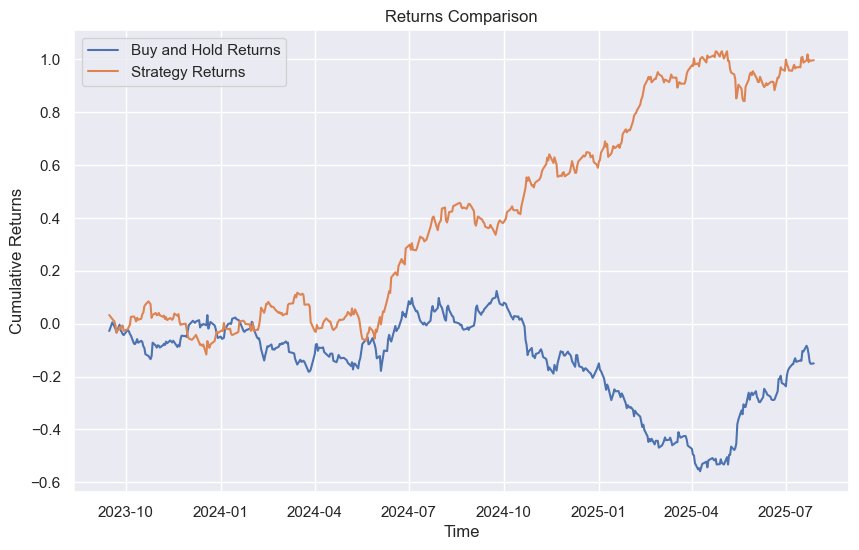

Price,Close,High,Low,Open,Volume,returns,std_5,std_10,std_15,ma_10,...,upper_band,middle_band,lower_band,macd,macdsignal,macdhist,sar,target,predicted,strategy_returns
Ticker,KAJARIACER.NS,KAJARIACER.NS,KAJARIACER.NS,KAJARIACER.NS,KAJARIACER.NS,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-15,1325.292725,1386.968670,1317.398204,1369.699406,188234,-0.027685,18.776543,44.017515,40.990931,1394.532605,...,1391.357299,1357.768799,1324.180298,-18.600818,-3.029365,-15.571453,1429.716355,1,1,0.032562
2023-09-18,1369.156616,1375.620304,1328.450492,1333.927364,239668,0.032562,17.856578,41.360470,40.565154,1387.338721,...,1388.764277,1356.821460,1324.878643,-18.772731,-6.178038,-12.594693,1416.238176,-1,1,-0.015032
2023-09-20,1348.729614,1374.140105,1336.147721,1366.738991,101776,-0.015032,17.891122,35.070213,42.507288,1376.641650,...,1386.191283,1354.186670,1322.182057,-20.322991,-9.007029,-11.315962,1404.377380,-1,1,-0.009225
2023-09-21,1336.344971,1353.713013,1333.976711,1348.729548,43856,-0.009225,18.089373,25.781084,44.864297,1365.253796,...,1380.763161,1348.403906,1316.044652,-22.293929,-11.664409,-10.629520,1393.939879,-1,1,-0.013643
2023-09-22,1318.236938,1360.768646,1312.760187,1336.344972,87357,-0.013643,20.177994,24.435102,45.821447,1356.101074,...,1375.647665,1339.552173,1303.456680,-25.028565,-14.337240,-10.691325,1384.754878,1,-1,-0.029104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-22,1241.599976,1268.500000,1225.199951,1262.500000,1380482,-0.009220,26.370761,28.204240,37.258183,1206.100000,...,1273.853433,1226.679980,1179.506528,50.264410,46.511348,3.753062,1198.599976,-1,-1,0.022068
2025-07-23,1214.500000,1254.900024,1202.199951,1254.900024,848289,-0.022068,14.859097,27.169013,32.894650,1209.159998,...,1259.440746,1232.859985,1206.279225,47.825787,46.774236,1.051551,1268.500000,-1,1,-0.029581


In [183]:


# Backtest the strategy
bnh_returns, s_returns, data = backtest(backtest_data, model)

data

In [184]:
print('Buy and Hold Returns:', bnh_returns)
print('Strategy Returns:', s_returns)

Buy and Hold Returns: -0.15222882782818545
Strategy Returns: 0.9970590099564169
